# Detecting communities
After having read paper "Fast unfolding of communities in large networks" written by Vincent D. Blondel, Jean-Loup Guillaume, Renaud Lambiotte and Etienne Lefebvre, I was feeling like trying it on some dataset.

<b>Resources:</b>

- Paper: https://arxiv.org/abs/0803.0476

- "Python-louvain" implementation: http://perso.crans.org/aynaud/communities/

## Import packages
Let's import all packages we need.

In [328]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

## Get data
I am just gonna consider NIPS papers of year 2014 and 2015.

In [329]:
# Get data
connect = sqlite3.connect('./database.sqlite')
query = """
SELECT pa.paper_id, pa.author_id, a.name
FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
JOIN authors as a ON pa.author_id = a.id
WHERE p.Year BETWEEN '2014' AND '2015'
"""
df = pd.read_sql(query, connect)

# Have a look at data
df.head(10)

,paper_id,author_id,name
0,5239,5654,Krikamol Muandet
1,5239,7140,Bharath Sriperumbudur
2,5239,1472,Prof. Bernhard Sch?lkopf
3,5591,5209,Yichuan Zhang
4,5591,7542,Charles Sutton
5,5597,7649,Mu Li
6,5597,7650,David G. Andersen
7,5597,6548,Alexander J. Smola
8,5597,2847,Kai Yu
9,5299,7226,Halid Z. Yerebakan


## Create graph

In [330]:
# Initialize graph
G = nx.Graph()

# Transform
# REMARK: The algorithm seems more stable by doing '*=2' than '+=1'
# REMARK: I use 'name' instead of 'author_id' for label purposes.
for p, a in df.groupby('paper_id')['name']: 
    for u, v in itertools.combinations(a, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] *= 2
        else:
            G.add_edge(u, v, weight=1)
            
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 3216


## Compute best partition

In [331]:
# Get best partition
partition = community.best_partition(G)
print('Modularity: ', community.modularity(partition, G))

Modularity:  0.954568399256756


In [332]:
# Display partitions
print('Partition: ', partition)

Partition:  {'Nan Li': 0, 'Rong Jin': 0, 'Zhi-Hua Zhou': 0, 'Fajwel Fogel': 1, "Alexandre d'Aspremont": 1, 'Milan Vojnovic': 1, 'Nisheeth Srivastava': 2, 'Ed Vul': 2, 'Paul R. Schrater': 2, 'Sewoong Oh': 3, 'Devavrat Shah': 3, 'Siu On Chan': 4, 'Ilias Diakonikolas': 4, 'Rocco A. Servedio': 4, 'Xiaorui Sun': 4, 'Aaron van den Oord': 5, 'Benjamin Schrauwen': 5, 'Robert A. Vandermeulen': 6, 'Clayton Scott': 6, 'Qiang Liu': 7, 'Alexander T. Ihler': 7, 'Joseph G. Makin': 8, 'Philip N. Sabes': 8, 'Isabel Valera': 9, 'Zoubin Ghahramani': 10, 'Kumar Dubey': 11, 'Qirong Ho': 11, 'Sinead A. Williamson': 11, 'Eric P. Xing': 11, 'Anqi Wu': 12, 'Mijung Park': 12, 'Oluwasanmi O. Koyejo': 13, 'Jonathan W. Pillow': 12, 'Balaji Lakshminarayanan': 14, 'Daniel M. Roy': 14, 'Yee Whye Teh': 14, 'Jason Chang': 7, 'John W. Fisher III': 7, 'Mehmet G?nen': 15, 'Adam A. Margolin': 15, 'Qichao Que': 16, 'Mikhail Belkin': 16, 'Yusu Wang': 16, 'Bo Dai': 9, 'Bo Xie': 9, 'Niao He': 9, 'Yingyu Liang': 9, 'Anant Raj':

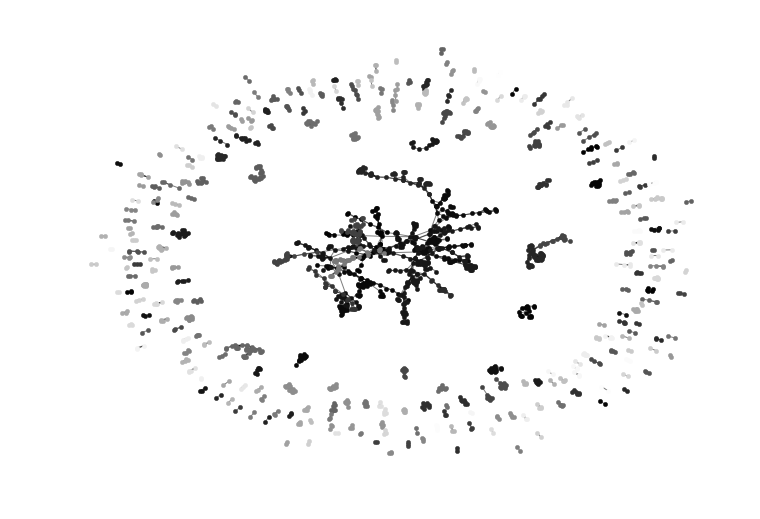

In [333]:
# Draw graph
plt.figure(figsize=(13, 9))
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = str(count / size))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis('off')
plt.show()

## Filter communities
Let's have a look at the largest communities detected. The ones with more than 30 members.

In [334]:
# Keep only communities with a minimum of authors
centers = {}
communities = {}
G_main_com = G.copy()
min_nb = 30
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_nb:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center
        # Print community
        print('Community of ', center , '(ID ', com, ') - ', len(list_nodes), ' authors:')
        print(list_nodes, '\n')

Community of  Prateek Jain (ID  3 ) -  47  authors:
['Sewoong Oh', 'Devavrat Shah', 'Arun Rajkumar', 'Shivani Agarwal', 'Prateek Jain', 'Ambuj Tewari', 'Purushottam Kar', 'Sujay Sanghavi', 'Guy Bresler', 'David Gamarnik', 'Deeparnab Chakrabarty', 'Pravesh Kothari', 'George H. Chen', 'Bruce Hajek', 'Jiaming Xu', 'Harikrishna Narasimhan', 'Sanjoy Dasgupta', 'Samory Kpotufe', 'Kamalika Chaudhuri', 'Shuang Song', 'Peter Kairouz', 'Pramod Viswanath', 'Praneeth Netrapalli', 'Niranjan U N', 'Animashree Anandkumar', 'Chicheng Zhang', 'Rohit Vaish', 'Hossein Azari Soufiani', 'David C. Parkes', 'Lirong Xia', 'Margareta Ackerman', 'Rafael Frongillo', 'Mark D. Reid', 'Qingqing Huang', 'Sham M. Kakade', 'Kiran K. Thekumparampil', 'Ian Kash', 'Yaron Singer', 'Jan Vondrak', 'Jimin Song', 'Kevin Chen', 'Kush Bhatia', 'Himanshu Jain', 'Manik Varma', 'Bo Waggoner', 'Jacob D. Abernethy', 'Chansoo Lee'] 

Community of  Le Song (ID  9 ) -  51  authors:
['Isabel Valera', 'Bo Dai', 'Bo Xie', 'Niao He', 'Ying

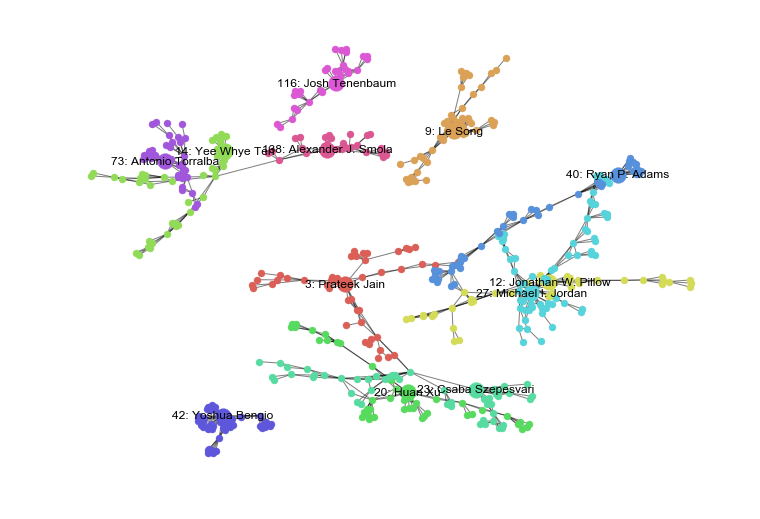

In [335]:
# Display graph
plt.figure(figsize=(13, 9))
node_size = 50
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
nx.draw_networkx_labels(G_main_com, pos, labels)
plt.axis('off')
plt.show()

In [336]:
# Display induced graph
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community.induced_graph(nodes_main_com, G_main_com)
print('Number of communities', len(ind.nodes()))
print('\nMain communities and their center node:', communities)

Number of communities 12

Main communities and their center node: {3: 'Prateek Jain', 9: 'Le Song', 12: 'Jonathan W. Pillow', 14: 'Yee Whye Teh', 20: 'Huan Xu', 23: 'Csaba Szepesvari', 27: 'Michael I. Jordan', 40: 'Ryan P. Adams', 42: 'Yoshua Bengio', 73: 'Antonio Torralba', 116: 'Josh Tenenbaum', 138: 'Alexander J. Smola'}


## Display induced graph
Let's now look at the induced graph, i.e. the graph of communities.

//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
//anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
//anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


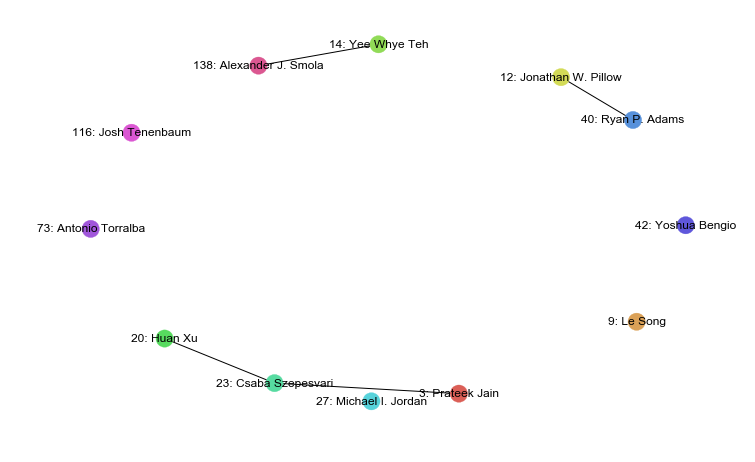

In [337]:
# Display induced graph
pos_ind = nx.spring_layout(ind)
labels = {k: str(k) + ': ' + v for k,v in communities.items()}
nx.draw(ind, pos_ind, node_list=list(colors.keys()), node_color=list(colors.values()), labels=labels)
plt.show()

A next step might be to analyze the papers by community (word count,...).